In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.mel_spectrogram_vae import MelSpectrogramVAE
from src.utils import audio_to_mel_spectrogram

In [45]:
sns.set(style='white')

In [46]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda RingMod"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES_PER_SETTING = 200
NUM_SETTINGS = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_melspec_vae/eu2tcrkn/checkpoints/epoch=237-step=74494.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
PEAK_NORMALISE = True

In [47]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [49]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING,
        augmentations={},
        length=130_560,
        effect_audio=False,
        dummy_setting=False
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [50]:
dafx = dafx_from_name(DAFX_NAME)

In [51]:
def get_interpolated_settings(dafx, setting_idx, num_samples=100):
    num_settings = len(dafx.param_names)

    assert(setting_idx <= num_settings)

    settings = []
    for i in np.linspace(0,1, num_samples):
        s = torch.ones(num_settings) * 0.5
        s[setting_idx] = i
        settings.append(s)

    return settings

In [52]:
settings_to_apply = get_interpolated_settings(dafx, 1, 10)

In [53]:
settings_to_apply

[tensor([0.5000, 0.0000, 0.5000]),
 tensor([0.5000, 0.1111, 0.5000]),
 tensor([0.5000, 0.2222, 0.5000]),
 tensor([0.5000, 0.3333, 0.5000]),
 tensor([0.5000, 0.4444, 0.5000]),
 tensor([0.5000, 0.5556, 0.5000]),
 tensor([0.5000, 0.6667, 0.5000]),
 tensor([0.5000, 0.7778, 0.5000]),
 tensor([0.5000, 0.8889, 0.5000]),
 tensor([0.5000, 1.0000, 0.5000])]

In [54]:
model = MelSpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

MelSpectrogramVAE(
  (encoder): Encoder(
    (_conv_1): Conv2d(1, 4, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (_conv_2): Conv2d(4, 8, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (_conv_3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (2): Resi

In [55]:
model.device

device(type='cuda', index=0)

In [56]:
latent_embeddings = dict()

In [57]:
dataset = get_dataset(dafx_from_name('clean'))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 32442.54it/s]


Loaded 88 files for train = 66.89 hours.


In [58]:
from tqdm import tqdm

for i in range(dafx.get_num_params()):
    setting_name = dafx.idx_to_param_map[i]
    print(f"Interpolating setting: {setting_name}")
    embeddings = []
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    for setting in settings_to_apply:
        print(f"Applying setting: {setting}")
        for batch in tqdm(dataset):
            x = batch

            # Apply setting to audio
            x = dafx.apply(x, setting)
            x = x.unsqueeze(0).unsqueeze(0)

            X = audio_to_mel_spectrogram(signal=x,
                                         sample_rate=model.hparams.sample_rate,
                                         n_mels=model.hparams.n_mels,
                                         n_fft=model.hparams.n_fft,
                                         win_length=model.hparams.win_length,
                                         f_max=model.hparams.f_max,
                                         f_min=model.hparams.f_min).to(DEVICE)

            _, _, _, z = model(X)

            embeddings.append(z.cpu().detach().numpy())

        latent_embeddings[setting_name] = np.array(embeddings)


Interpolating setting: freq_hz
Applying setting: tensor([0.0000, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 33.39it/s]


Applying setting: tensor([0.1111, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 36.54it/s]


Applying setting: tensor([0.2222, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 36.34it/s]


Applying setting: tensor([0.3333, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 37.98it/s]


Applying setting: tensor([0.4444, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 36.02it/s]


Applying setting: tensor([0.5556, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 37.68it/s]


Applying setting: tensor([0.6667, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 38.39it/s]


Applying setting: tensor([0.7778, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 36.80it/s]


Applying setting: tensor([0.8889, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 38.01it/s]


Applying setting: tensor([1.0000, 0.5000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 35.23it/s]


Interpolating setting: fine_hz
Applying setting: tensor([0.5000, 0.0000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 37.24it/s]


Applying setting: tensor([0.5000, 0.1111, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 34.81it/s]


Applying setting: tensor([0.5000, 0.2222, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 37.91it/s]


Applying setting: tensor([0.5000, 0.3333, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 36.60it/s]


Applying setting: tensor([0.5000, 0.4444, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 38.89it/s]


Applying setting: tensor([0.5000, 0.5556, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 35.75it/s]


Applying setting: tensor([0.5000, 0.6667, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 37.48it/s]


Applying setting: tensor([0.5000, 0.7778, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 36.86it/s]


Applying setting: tensor([0.5000, 0.8889, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 36.68it/s]


Applying setting: tensor([0.5000, 1.0000, 0.5000])


100%|██████████| 200/200 [00:05<00:00, 37.81it/s]


Interpolating setting: feedback
Applying setting: tensor([0.5000, 0.5000, 0.0000])


100%|██████████| 200/200 [00:05<00:00, 38.39it/s]


Applying setting: tensor([0.5000, 0.5000, 0.1111])


100%|██████████| 200/200 [00:05<00:00, 38.87it/s]


Applying setting: tensor([0.5000, 0.5000, 0.2222])


100%|██████████| 200/200 [00:05<00:00, 33.57it/s]


Applying setting: tensor([0.5000, 0.5000, 0.3333])


100%|██████████| 200/200 [00:05<00:00, 37.05it/s]


Applying setting: tensor([0.5000, 0.5000, 0.4444])


100%|██████████| 200/200 [00:05<00:00, 34.23it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5556])


100%|██████████| 200/200 [00:05<00:00, 35.45it/s]


Applying setting: tensor([0.5000, 0.5000, 0.6667])


100%|██████████| 200/200 [00:06<00:00, 32.09it/s]


Applying setting: tensor([0.5000, 0.5000, 0.7778])


100%|██████████| 200/200 [00:09<00:00, 20.11it/s]


Applying setting: tensor([0.5000, 0.5000, 0.8889])


100%|██████████| 200/200 [00:09<00:00, 21.54it/s]


Applying setting: tensor([0.5000, 0.5000, 1.0000])


100%|██████████| 200/200 [00:06<00:00, 31.45it/s]


In [59]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [60]:
data.shape

(6000, 128)

In [61]:
import umap

In [62]:
# reducer = umap.UMAP(n_neighbors=10, min_dist=.1, metric='chebyshev').fit(data)
reducer = umap.UMAP(min_dist=.1).fit(data)

In [63]:
EXPERIMENT_NAME = f"{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{NUM_SETTINGS}settings"

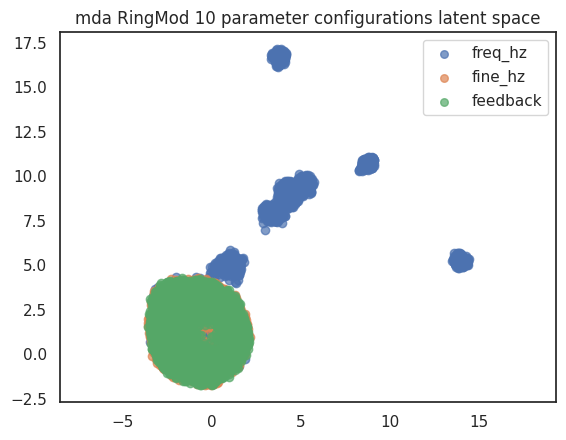

In [64]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.7)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_full.png"
plt.savefig(figname)

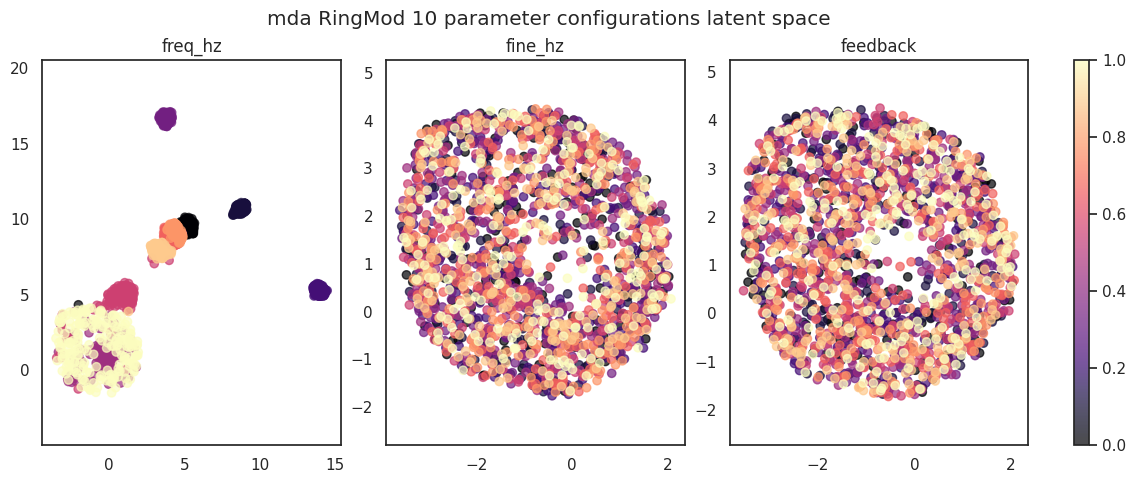

In [65]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(4.5*dafx.get_num_params(), 5))
gs = gridspec.GridSpec(1, dafx.get_num_params() + 1, width_ratios=[1]*dafx.get_num_params() + [0.05])

for i in range(dafx.get_num_params()):
    param_name = dafx.idx_to_param_map[i]
    X = latent_embeddings[param_name]

    embeds = reducer.transform(X.squeeze())
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    colours = np.array([np.array([setting[i]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])

    ax = fig.add_subplot(gs[0, i])
    sc = ax.scatter(x=embeds[:,0], y=embeds[:,1], alpha=0.7, c=colours, vmin=0, vmax=1, cmap='magma')

    ax.set_title(param_name)
    ax.set_aspect('equal', 'datalim')

plt.suptitle(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(sc, cax=cax)

fig.subplots_adjust(right=0.9)

figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_seperate.png"
plt.savefig(figname)